In [175]:
%matplotlib inline

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import utils
import gpfunctions as gp
import lstm_model
tf.logging.set_verbosity(tf.logging.ERROR)

In [135]:
DIM=2
N_BUMPS = 6
LENGTH = 2/N_BUMPS*np.sqrt(DIM)

X_PLOT_RANGE = 100
X_PLOT_LIMIT = 2

XX1 = np.linspace(-X_PLOT_LIMIT, X_PLOT_LIMIT, X_PLOT_RANGE)
XX2 = np.linspace(-X_PLOT_LIMIT, X_PLOT_LIMIT, X_PLOT_RANGE)
XX = np.array(np.meshgrid(XX1,XX2)).T.reshape(1,-1,2)
print(XX.T.shape)
X_2d, A_2d, Min_2d, Max_2d = utils.loadData(DIM, 'testing', kernel = 'rbf')

(2, 10000, 1)


In [137]:
print(XX[0,:])

[[-2.         -2.        ]
 [-2.         -1.95959596]
 [-2.         -1.91919192]
 ..., 
 [ 2.          1.91919192]
 [ 2.          1.95959596]
 [ 2.          2.        ]]


In [148]:
def plot_gp_function(f_values, sampling_points, colorbar=False):
    
    extend = [-X_PLOT_LIMIT,X_PLOT_LIMIT,-X_PLOT_LIMIT,X_PLOT_LIMIT]
    f_values = f_values.reshape(X_PLOT_RANGE,X_PLOT_RANGE).T

    plt.imshow(f_values, cmap='hot', interpolation='nearest', extent=extend, origin="lower", vmin=-1, vmax=1)
   
    if colorbar:
        plt.colorbar()

    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.scatter(sampling_points[:,0], sampling_points[:,1], color = "green", marker = "x")
    for i in range(len(sampling_points)):
        curr = sampling_points[i]
        plt.text(curr[0], curr[1], str(i), fontsize=12, color="black")
        
def plot_line_mark(x1,y1, limit=2):
    X_PLOT_LIMIT = limit
    plt.plot([x1, x1], [-X_PLOT_LIMIT, X_PLOT_LIMIT], 'w-', lw=0.5)
    plt.plot([-X_PLOT_LIMIT, X_PLOT_LIMIT], [y1,y1] , 'w-', lw=0.5)

In [150]:
def evaluate_gp_ith_with_model(data_index,model,dim, debug=False):    

    data_Xt = X_2d[data_index]
    data_At  = A_2d[data_index].reshape(1,-1,1)
    data_mint = Min_2d[data_index].reshape(-1,1)
    data_maxt = Max_2d[data_index].reshape(-1,1)

    res = None

    model_params = lstm_model.load_model_params(model)
    
    with tf.Session() as sess:
        params_dict = {
            'n_bumps': model_params['n_bumps'],
            'dim' : model_params['dim'],
            'n_hidden': model_params['n_hidden'],
            'forget_bias': model_params['forget_bias'],
            'n_steps': model_params['n_steps'],
            'l': model_params['gp_length'],
            'scope': model_params['scope']
        }
        
        Xt, At, mint, maxt, samples_x, samples_y, x_0,_, _ = lstm_model.build_training_graph(**params_dict)
        
        saver = tf.train.Saver()
        saver.restore(sess, model_params['model_path'])

        feed_dict = {
            Xt: data_Xt.reshape(1,-1,dim),
            At: data_At,
            mint: data_mint,
            maxt: data_maxt,
            x_0: np.array([-1,-1]).reshape(1,-1)
        }

        
        sample_y, sample_x = sess.run([samples_y, samples_x], feed_dict=feed_dict)
        sample_y = np.array(sample_y).reshape(-1,1).T
        sample_x = np.array(sample_x).reshape(-1,1, model_params['dim']).transpose((1,0,2)).reshape(-1,model_params['dim'])
        return sample_y, sample_x

INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1498485717/model


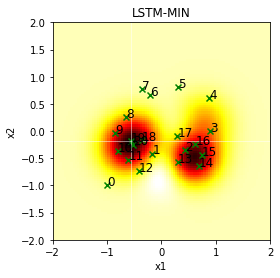

In [160]:
def compute_gp_function_values(xx, data_idx=1, kernel='rbf'):
    X = np.expand_dims(X_2d[data_idx], axis=0)
    A = A_2d[data_idx]
    miv = Min_2d[data_idx]
    mxv = Max_2d[data_idx]

    y = gp.normalized_gp_function('np', X,A, miv, mxv, l=LENGTH, kernel = gp.kernel_function(kernel), x = xx)
    return y

def plot_loss_function_on_gp( loss, data_idx=300, kernel='rbf' ):
    model = utils.get_trained_model(dim=2, kernel=kernel, loss=loss)    
    
    f_values = compute_gp_function_values(XX, data_idx=data_idx, kernel=kernel)
    
    sample_y, sample_x = evaluate_gp_ith_with_model(data_idx, model, dim=2)
    min_idx = np.argmin(sample_y)
    plot_gp_function( f_values, sample_x)
    plt.title('LSTM-%s' % loss )
    plot_line_mark(*sample_x[min_idx, :])

plot_loss_function_on_gp(loss='MIN')

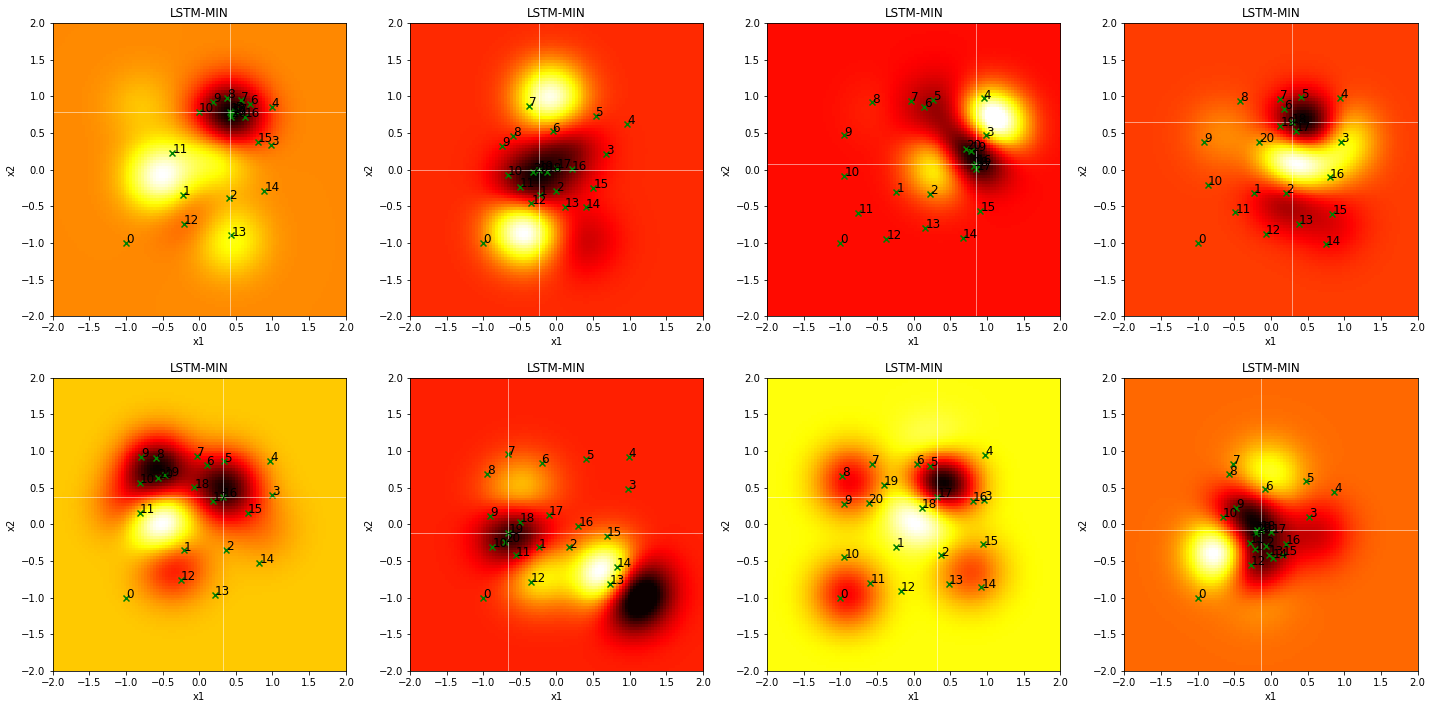

In [180]:
def plot_with_several_data(loss='MIN', data= [10,111,20,30,1111,999,888,400]):
    plt.figure(figsize=(20,10))
    count = 1
    for i in data:
        plt.subplot(int(len(data)/4.0),4,count)
        plot_loss_function_on_gp(loss=loss, data_idx=i)
        count = count + 1
    plt.tight_layout()

plot_with_several_data('MIN')

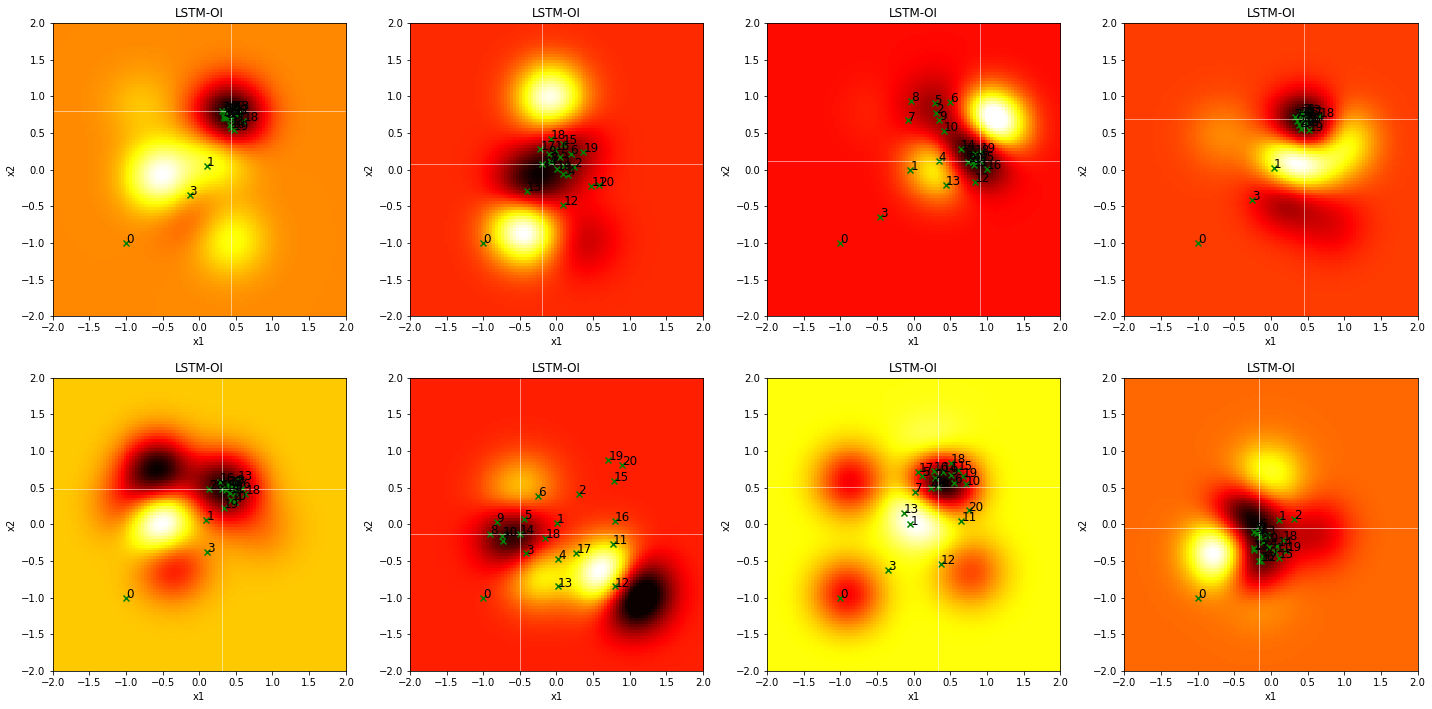

In [181]:
plot_with_several_data('OI')

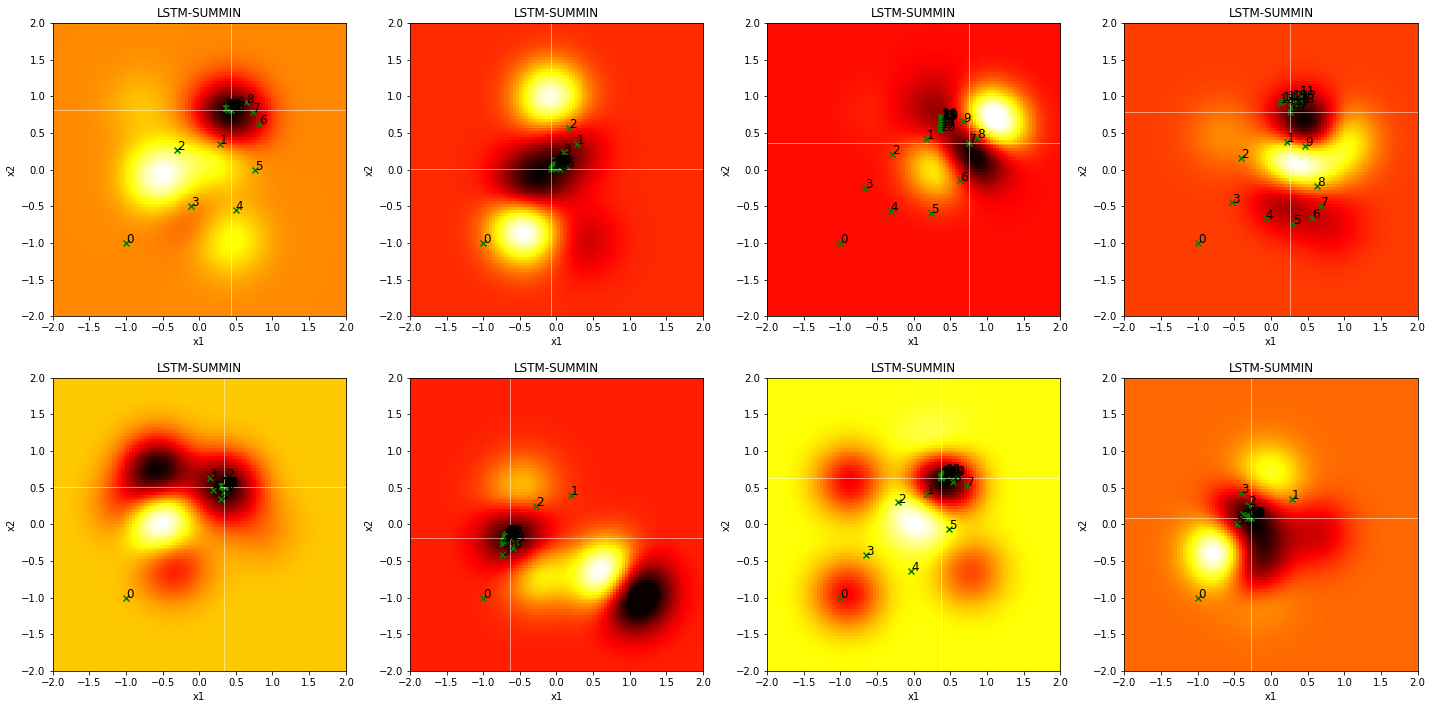

In [182]:
plot_with_several_data('SUMMIN')

INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1498485717/model
INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1498487245/model
INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1498486433/model
INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1498487978/model


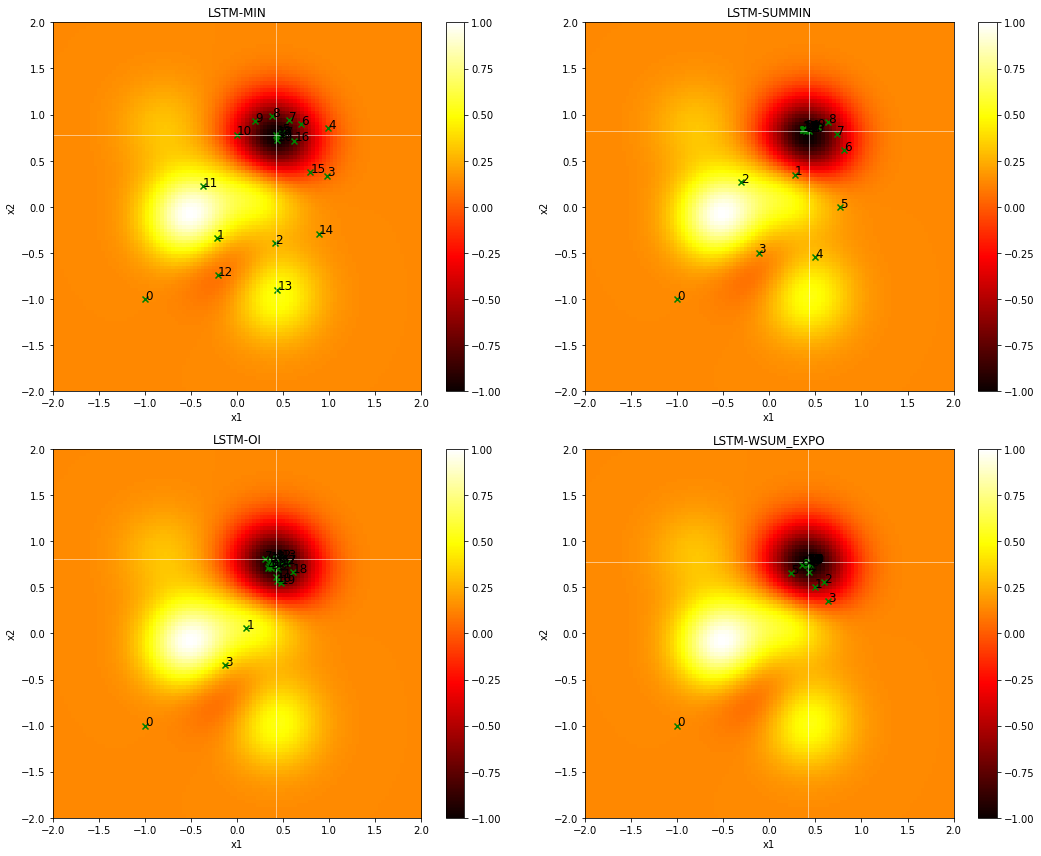

In [155]:
plt.figure(figsize=(15,12))
count = 1
for loss in ['MIN','SUMMIN', 'OI','WSUM_EXPO']:
    plt.subplot(2,2, count)
    plot_loss_function_on_gp(loss=loss, data_idx=10)
    count = count + 1
plt.tight_layout()